# Stats for the cognitive data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pds
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import make_machine_learning_df, make_pd_cog_contingency_table, plot_hist_row, plot_countplot_row, add_age_cal_class
from scipy.stats import hypergeom, fisher_exact, chi2_contingency
from scipy.stats.contingency import odds_ratio

## load training data
- `train_df` holds data adjusted with the survey weights
- `base_df` holds non-adjusted survey weight data

In [3]:
train_df = make_machine_learning_df(weight_divisor=100)
base_df = make_machine_learning_df(use_survey_weight=False)

### descriptive statistics

#### number of subjects

In [4]:
print(f'adjusted len:{len(train_df)} \nbase/raw len: {len(base_df)}')

adjusted len:85564 
base/raw len: 313


#### gender breakdown

In [5]:
train_df.female.value_counts()

0    53904
1    31660
Name: female, dtype: int64

In [6]:
# train_df.head(2)

#### count plots of low cognitive score

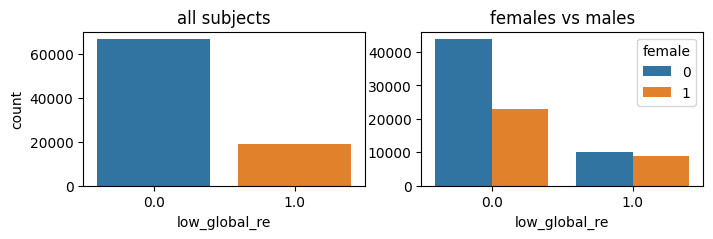

In [7]:
dfs = [train_df, train_df]
titles = ["all subjects", "females vs males"]
plot_countplot_row(dfs, 'low_global_re', titles=titles, hues=[None, 'female'], figsize=(8, 2)).show()

### age and cognitive score

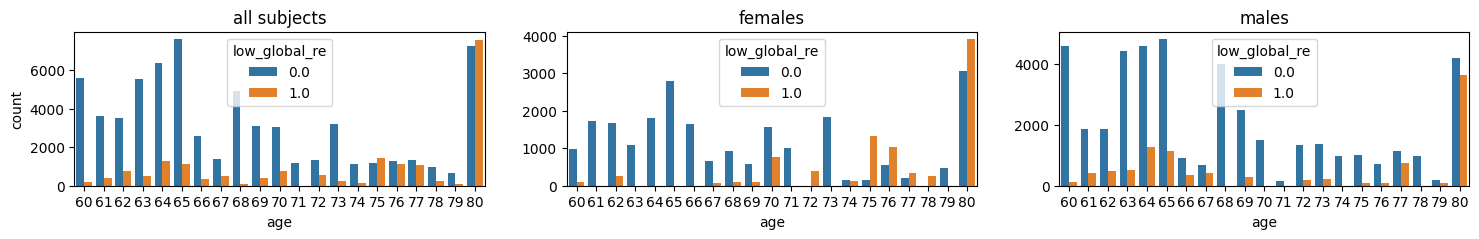

In [8]:
dfs = [train_df, train_df.query("female == 1"), train_df.query("female == 0")]
titles = ["all subjects", "females", "males"]
hues = ['low_global_re', 'low_global_re', 'low_global_re']
plot_countplot_row(dfs, 'age', titles=titles, hues=hues, figsize=(18,2)).show()

#### create age and CAL class dataset

In [9]:
age_cal_class_df = train_df.copy()
age_cal_class_df = add_age_cal_class(age_cal_class_df)

#### create gender specific age and CAL class datasets

In [10]:
female_age_cal_class_df = age_cal_class_df.query("female == 1")
male_age_cal_class_df = age_cal_class_df.query("female == 0")

In [11]:
# temp_df.head(2)

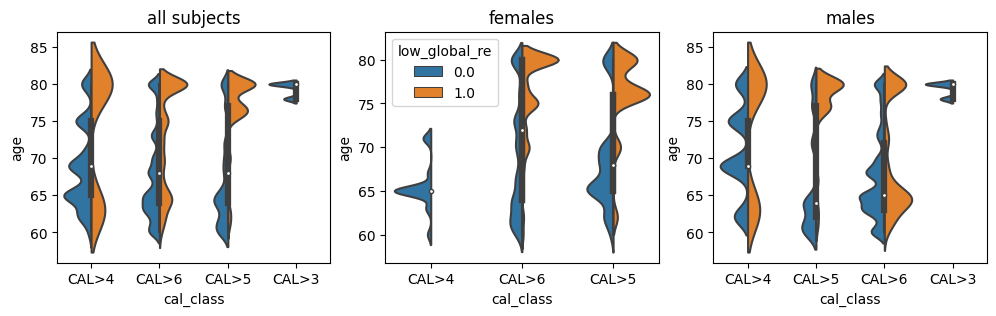

<Figure size 1200x200 with 0 Axes>

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
plt.figure(figsize=(12, 2))
sns.violinplot(data=age_cal_class_df, x='cal_class',y='age',hue='low_global_re', split=True, ax=axs[0]).set(title="all subjects")
sns.violinplot(data=female_age_cal_class_df, x='cal_class',y='age',hue='low_global_re', split=True, ax=axs[1]).set(title="females")
sns.violinplot(data=male_age_cal_class_df, x='cal_class',y='age',hue='low_global_re', split=True, ax=axs[2]).set(title="males")
sns.move_legend(axs[1], 'upper left')
axs[0].get_legend().remove()
axs[2].get_legend().remove()
plt.show()

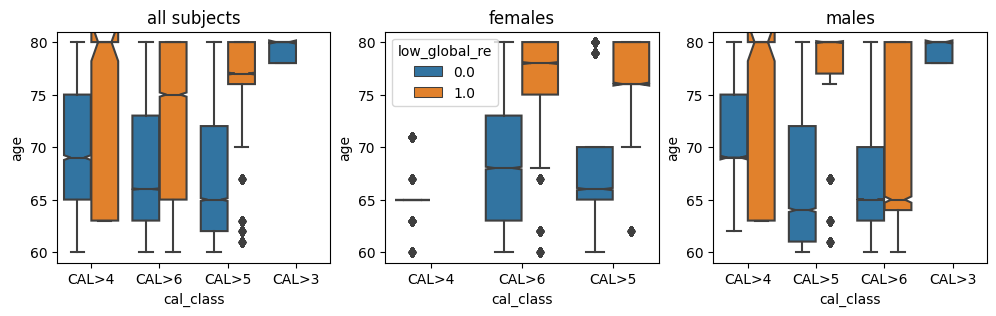

<Figure size 1200x200 with 0 Axes>

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
plt.figure(figsize=(12, 2))
sns.boxplot(data=age_cal_class_df, x='cal_class',y='age',hue='low_global_re', ax=axs[0], notch=True).set(title="all subjects")
sns.boxplot(data=female_age_cal_class_df, x='cal_class',y='age',hue='low_global_re', ax=axs[1], notch=True).set(title="females")
sns.boxplot(data=male_age_cal_class_df, x='cal_class',y='age',hue='low_global_re', ax=axs[2], notch=True).set(title="males")
sns.move_legend(axs[1], 'upper left')
axs[0].get_legend().remove()
axs[2].get_legend().remove()
plt.show()

**create heatmaps**  
In the heatmaps, the color represents the percentage of subjects in that the age class with a low cognitive score.  
For example, in the heatmap for all subjects, 52% of the subjects aged 80+ and a CAL > 6mm have a low cogntive score.  
The CAL classes divide the subjects in groups according to the highest level of CAL recorded.

[Text(0.5, 1.0, 'males'), Text(777.1928104575164, 0.5, '')]

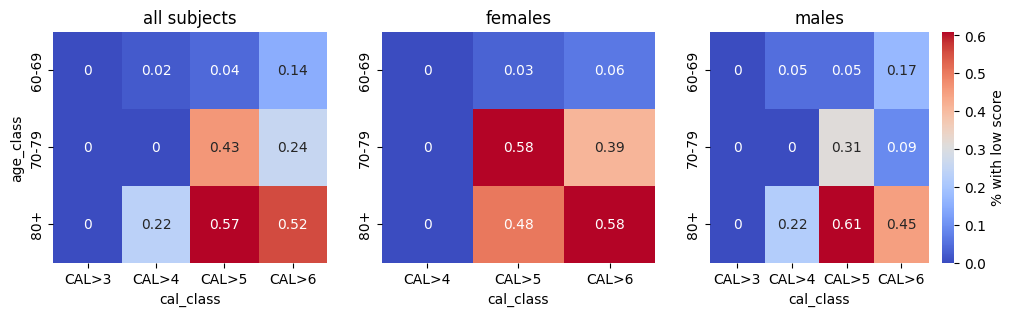

<Figure size 1200x200 with 0 Axes>

In [14]:
def calc_pct(x):
    return round(sum(x)/len(x), 2)

# create dataframes for heatmaps
plot_df = age_cal_class_df.pivot_table(
    index='age_class', columns='cal_class', values='low_global_re', aggfunc=calc_pct, fill_value=0)
female_plot_df = female_age_cal_class_df.pivot_table(
    index='age_class', columns='cal_class', values='low_global_re', aggfunc=calc_pct, fill_value=0)
male_plot_df = male_age_cal_class_df.pivot_table(
    index='age_class', columns='cal_class', values='low_global_re', aggfunc=calc_pct, fill_value=0)

fig, axs = plt.subplots(1, 3, figsize=(12, 3))
plt.figure(figsize=(12, 2))
sns.heatmap(data=plot_df, cmap='coolwarm', annot=True, ax=axs[0], cbar=False).set(title="all subjects")
sns.heatmap(data=female_plot_df, cmap='coolwarm', annot=True, ax=axs[1], cbar=False).set(title="females", ylabel="")
sns.heatmap(
    data=male_plot_df, cmap='coolwarm', annot=True, ax=axs[2], cbar_kws={'label': '% with low score'}).set(title="males", ylabel="")


### age distribution

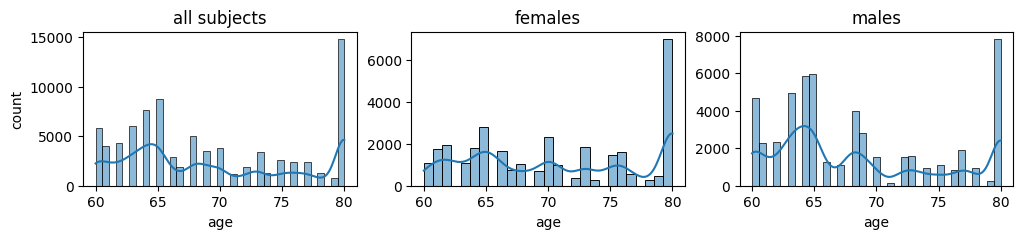

In [15]:
dfs = [train_df, train_df.query("female == 1"), train_df.query("female == 0")]
titles = ["all subjects", "females", "males"]
plot_hist_row(dfs, x='age', titles=titles).show()

#### percentages of clinical attachment loss

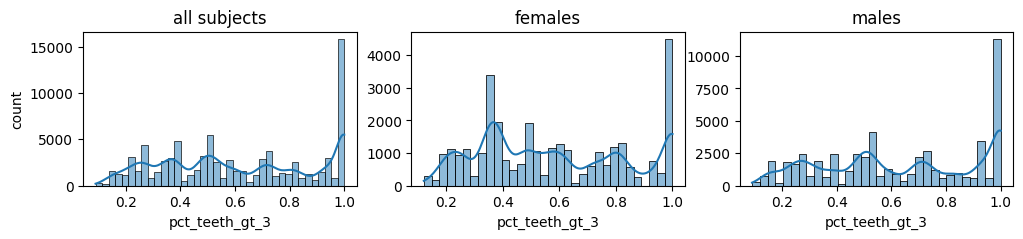

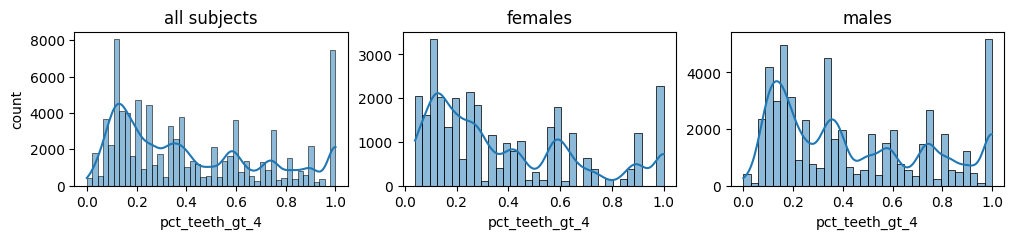

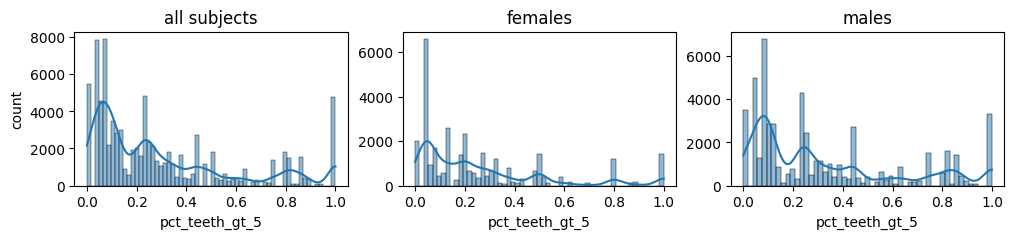

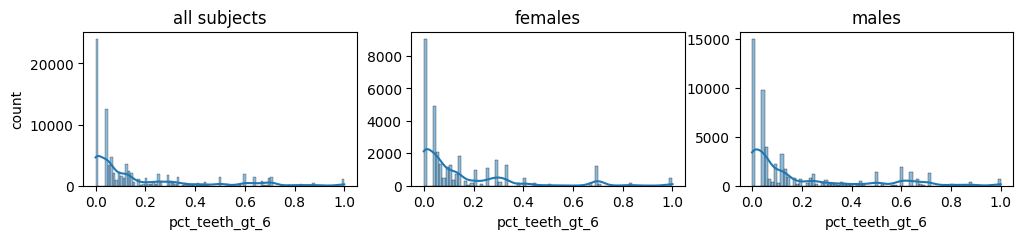

In [16]:
dfs = [train_df, train_df.query("female == 1"), train_df.query("female == 0")]
titles = ["all subjects", "females", "males"]
plot_hist_row(dfs, x='pct_teeth_gt_3', titles=titles).show()
plot_hist_row(dfs, x='pct_teeth_gt_4', titles=titles).show()
plot_hist_row(dfs, x='pct_teeth_gt_5', titles=titles).show()
plot_hist_row(dfs, x='pct_teeth_gt_6', titles=titles).show()

## hypergeom
M - the total number of objects   
n - total number of Type I objects  
N - number of Type I objects randomly drawn without replacement from the total population (M)  
k or x - number of successes

n: number of successes in the population = **number of patients with the low cognitive score**  
N: sample size (number of object randomly drawn) = **number of patients with PD**  
x: **number of patients with PD & low cognitive score**  

In [17]:
print('size of population:', len(train_df))
print('number of patients with low scrore:', 
      len(train_df.query("low_global_re == 1.0")))

print('\nnumber of PD patients')
print('CAL > 3mm :', len(train_df.query("pct_teeth_gt_3 > 0")))
print('CAL > 4mm:', len(train_df.query("pct_teeth_gt_4 > 0")))
print('CAL > 5mm:', len(train_df.query("pct_teeth_gt_5 > 0")))
print('CAL > 6mm:', len(train_df.query("pct_teeth_gt_6 > 0")))

print('\nnumber of PD patients with low score')
print('CAL > 3mm & low score:', 
      len(train_df.query("(pct_teeth_gt_3 > 0) and (low_global_re == 1.0)")))
print('CAL > 4mm & low score:', 
      len(train_df.query("(pct_teeth_gt_4 > 0) and (low_global_re == 1.0)")))
print('CAL > 5mm & low score:', 
      len(train_df.query("(pct_teeth_gt_5 > 0) and (low_global_re == 1.0)")))
print('CAL > 6mm & low score:', 
      len(train_df.query("(pct_teeth_gt_6 > 0) and (low_global_re == 1.0)")))

size of population: 85564
number of patients with low scrore: 18849

number of PD patients
CAL > 3mm : 85564
CAL > 4mm: 85150
CAL > 5mm: 80075
CAL > 6mm: 61545

number of PD patients with low score
CAL > 3mm & low score: 18849
CAL > 4mm & low score: 18849
CAL > 5mm & low score: 18631
CAL > 6mm & low score: 14091


In [18]:
M = 85_564
n = 18_849
N = 85_564 
x = 14_091

In [19]:
pval = hypergeom.sf(x-1, M, n, N)
round(pval, 4)

1.0

---

## odds ratio
OR = (odds in exposed group) / (odds in not exposed group)
exposed group = number of patient with low score / number of patients with PD
not expossed group = number of patients w/o low score / number of patients with PD

In [20]:
ctg_table = make_pd_cog_contingency_table(train_df, 'pct_teeth_gt_5', 'low_global_re')

In [21]:
odds_ratio(ctg_table).statistic

7.331408706809558

## fisher exact test

In [22]:
ctg_table = make_pd_cog_contingency_table(train_df, 'pct_teeth_gt_5', 'low_global_re')

In [23]:
oddsratio, pvalue = fisher_exact(ctg_table, alternative='two-sided')
print(oddsratio, pvalue)

7.331506230182597 0.0


In [24]:
oddsratio, pvalue = fisher_exact(ctg_table, alternative='greater')
print(oddsratio, pvalue)

7.331506230182597 0.0


In [25]:
oddsratio, pvalue = fisher_exact(ctg_table, alternative='less')
print(oddsratio, pvalue)

7.331506230182597 1.0


## Chi-squared
Both columns are categories. So, use chi-squared instead of t-test

In [26]:
ctg_table = make_pd_cog_contingency_table(train_df, 'pct_teeth_gt_4', 'low_global_re')

In [27]:
chi2_statistic, pvalue, dof, expected_freq = chi2_contingency(ctg_table)
print(chi2_statistic, pvalue, dof, expected_freq)

116.25095240276023 4.188027441329969e-27 1 [[  322.79942499    91.20057501]
 [66392.20057501 18757.79942499]]


## create some tests using different levels of percentages

In [28]:
# build contingency table
pct_field = 'pct_teeth_gt_6'
table_by_pct = pds.DataFrame (
    {
        'pd_25': [1.0 if (val > 0.0 and val <= 25.0) else 0 for val in train_df[pct_field]],
        'pd_50': [1.0 if (val > 25.0 and val <= 50.0) else 0 for val in train_df[pct_field]],
        'pd_75': [1.0 if (val > 50.0 and val <= 75.0) else 0 for val in train_df[pct_field]],
        'pd_100': [1.0 if (val > 75.0 and val <= 100.0) else 0 for val in train_df[pct_field]],
        'low_score': train_df.low_global_re.values
    }
)
ctg_table_pct = pds.crosstab(table_by_pct['pd_25'], table_by_pct['low_score'])
ctg_table_pct

low_score,0.0,1.0
pd_25,,
0.0,19261,4758
1.0,47454,14091


In [29]:
chi2_statistic, pvalue, dof, expected_freq = chi2_contingency(ctg_table_pct)
print(chi2_statistic, pvalue, dof, expected_freq)

95.61785521018648 1.3934397079137122e-22 1 [[18727.82461082  5291.17538918]
 [47987.17538918 13557.82461082]]
